## RFM Segmentation/Analysis

### 1) What is RFM analysis?

#### RFM Analysis divides users into segments depending on:

• **Recency**: How much time has elapsed since a customer'scustomer's last activity or transaction with the brand? Activity is usually a purchase, although variations are sometimes used, e.g., the last visit to a website or a mobile app. In most cases, the more recently a customer has interacted or transacted with a brand, the more likely that customer will be responsive to communications from the brand.

• **Frequency**: How often has a customer transacted or interacted with the brand during a particular period? Customers with frequent activities are more engaged and more loyal than customers who rarely do so. And one-time-only customers are in a class of their own.

• **Monetary**: Also referred to as"  "monetary value,"" this factor reflects how much a customer has spent with the brand during a particular period. Big spenders should usually be treated differently than customers who spend little. Looking at monetary divided by frequency indicates the average purchase amount – a crucial secondary factor to consider when segmenting customers.

## 2) Performing RFM Segmentation and RFM Analysis

1. 3 indicators (Recency, Frequency, Monetary) need to be assigned separately for each customer.

2. Assign grades from 1-3 or 1-5 based on the results. The wider the range, the narrower the segments we get.

3. Grades can be set using quantiles. We sort the data according to one of the criteria and divide it into equal groups.

4. Visualizing results

## 3) Project Flow

1. Use the public dataset: https://www.kaggle.com/olistbr/brazilian-ecommerce, namely olist_orders_dataset.csv and olist_order_payments_dataset.csv files.  
2. Import all the necessary libraries and read the files.

In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from datetime import date,timedelta
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')

3. Convert the date of delivery of the order by the original carrier (order_delivered_carrier_date) to datetime64. -> as we are going to base our calculations on it.
4. Create an index order_id and connect the datasets through it.

In [8]:
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'])
df_payments = df_payments.set_index('order_id')
df_orders = df_orders.set_index('order_id')
order_payment = df_orders.join(df_payments)

5. Since the dataset is not recent, we will use max + 1 instead of the current date. To create Recency, Frequency and Monetary for every customer, group the records through customer_id.

In [13]:
last_date = order_payment['order_delivered_carrier_date'].max() + timedelta(days=1)
rfmTable = order_payment.reset_index().groupby('customer_id').agg({'order_delivered_carrier_date': lambda x: (last_date - x.max()).days,
                                                 'order_id': lambda x: len(x), 
                                                 'payment_value': lambda x: x.sum()})
rfmTable.rename(columns={'order_delivered_carrier_date': 'Recency', 
                          'order_id': 'Frequency', 
                          'payment_value': 'Monetary_value'}, inplace=True)

6. Check the first 10 Table rows!

In [14]:
rfmTable.head(10) # test first 10 values

,Recency,Frequency,Monetary_value
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,299.0,1,114.74
000161a058600d5901f007fab4c27140,420.0,1,67.41
0001fd6190edaaf884bcaf3d49edf079,560.0,1,195.42
0002414f95344307404f0ace7a26f1d5,389.0,1,179.35
000379cdec625522490c315e70c7a9fb,161.0,1,107.01
0004164d20a9e969af783496f3408652,518.0,1,71.80
000419c5494106c306a97b5635748086,188.0,1,49.40
00046a560d407e99b969756e0b10f282,267.0,1,166.59
00050bf6e01e69d5c0fd612f1bcfb69c,358.0,1,85.23


7. Assigning grades. Split into a range from 1 to 5. The wider the range, the more accurate our groups are, but at the same time, it is more challenging to work with a large number of combinations.

8. Segmented_rfm Table is ready! RFM score of 413 means: r_quartile = 4, f_quartile = 1, m_quartile = 3.

In [17]:
quantiles = rfmTable.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

def RScore(x,p,d):
     if x <= d[p][0.20]:
         return 1
     elif x <= d[p][0.40]:
         return 2
     elif x <= d[p][0.60]: 
         return 3
     elif x<=d[p][0.80]:
         return 4
     else:
         return 5

segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['Frequency'].apply(RScore, args=('Frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['Monetary_value'].apply(RScore, args=('Monetary_value',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
print(segmented_rfm.head())

                                  Recency  Frequency  Monetary_value  \
customer_id                                                            
00012a2ce6f8dcda20d059ce98491703    299.0          1          114.74   
000161a058600d5901f007fab4c27140    420.0          1           67.41   
0001fd6190edaaf884bcaf3d49edf079    560.0          1          195.42   
0002414f95344307404f0ace7a26f1d5    389.0          1          179.35   
000379cdec625522490c315e70c7a9fb    161.0          1          107.01   

                                  r_quartile  f_quartile  m_quartile RFMScore  
customer_id                                                                    
00012a2ce6f8dcda20d059ce98491703           4           1           3      413  
000161a058600d5901f007fab4c27140           5           1           2      512  
0001fd6190edaaf884bcaf3d49edf079           5           1           4      514  
0002414f95344307404f0ace7a26f1d5           4           1           4      414  
000379cdec62552

9. Separately, the average recency/frequency/monetary_value values for all RFMScore can be seen using matplotlib.

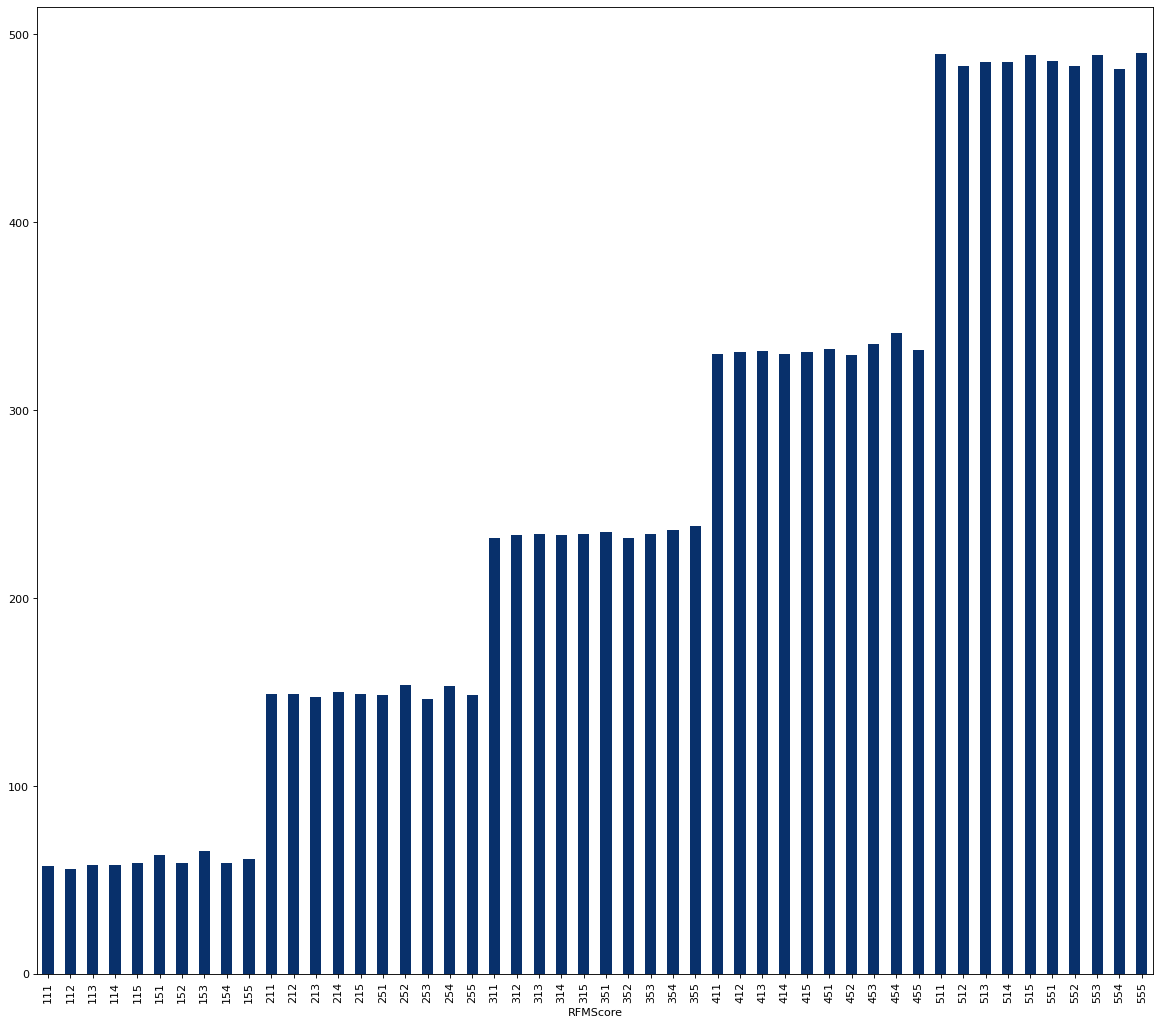

In [20]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('Recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

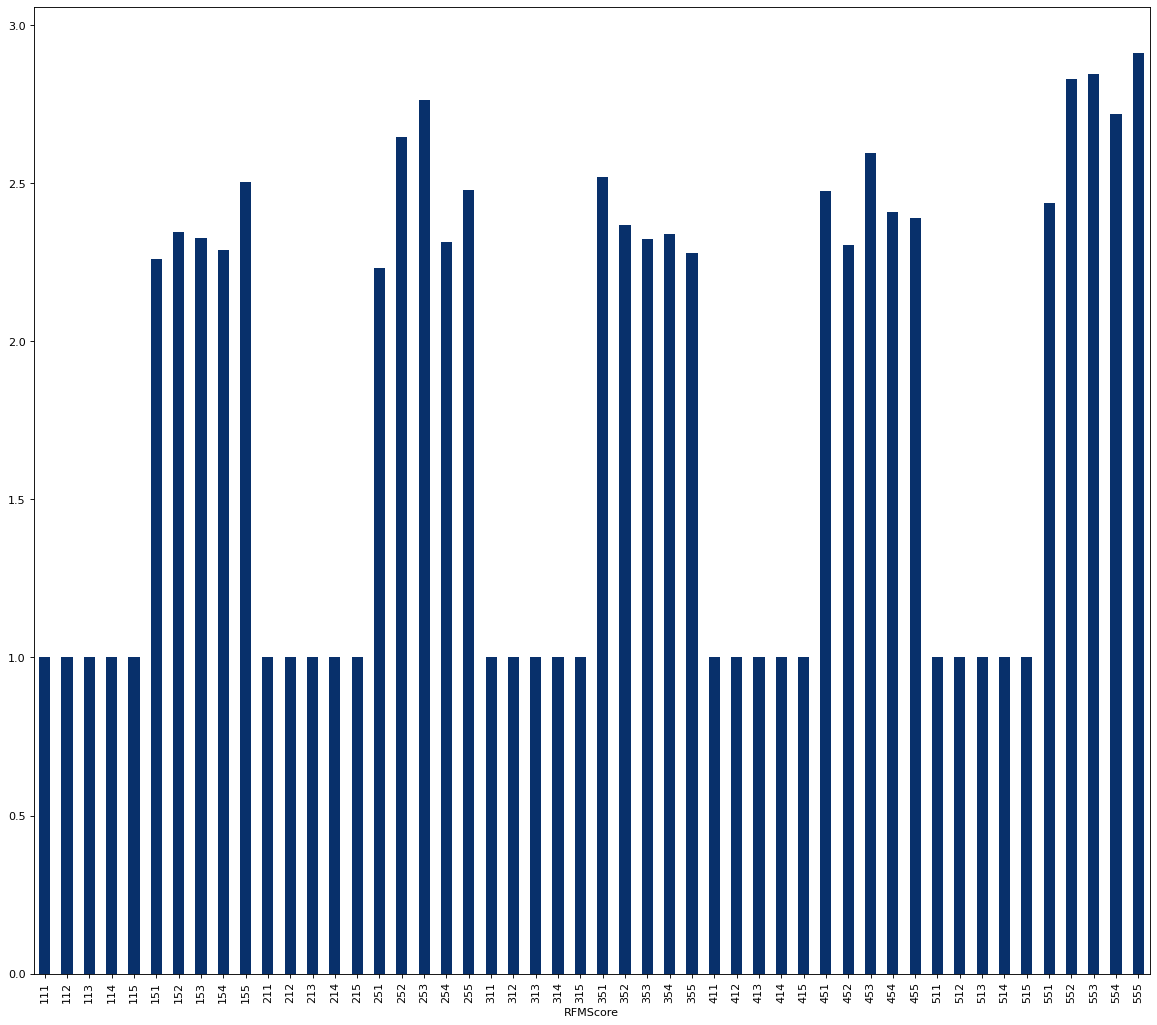

In [21]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('Frequency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

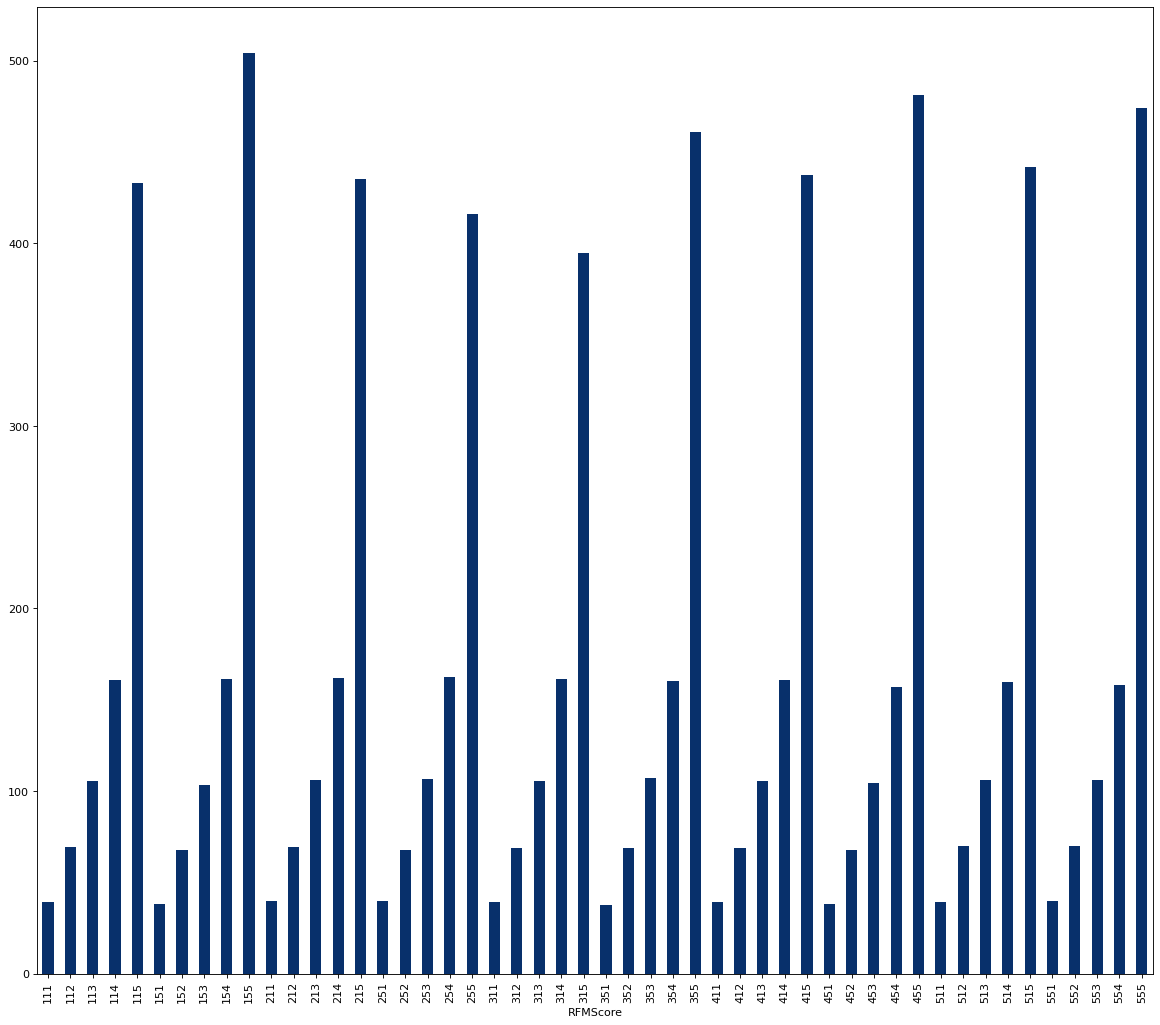

In [23]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('Monetary_value').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

## 4) Application

#### RFM analysis aims to form segments to craft specific messaging tailored for each customer group. By focusing on the behavioral patternsof particular groups, RFM marketing allows marketers to communicate with customers much more effectively. For example: offer a bonus/sale, benefit, send a push or email notification. It'sIt's essential to do this in a targeted manner.

#### The effect of using RFM analysis can be as follows: customer retention, increased income, increased customer loyalty.

#### ➭ **Examples of interpretation of RFM analysis segments:**

• Best Customers: R = 5, F = 5, M = 5 - Customers that pay often, a lot and recently. The most loyal and active users. Communications with this group should make them feel valued and appreciated. These customers likely generate a disproportionately high percentage of overall revenues, and thus focusing on keeping them happy should be a top priority. Further analyzing their individual preferences and affinities will provide additional opportunities for even more personalized messaging.

• Lost Customers: R = 1, F = 1, M = 1 - they pay little, rarely and stopped transacting a long time ago. Most likely lost clients. It may not be worth taking action to return them if the acquisition price is higher than the expected profit.

• Churned Best Customers: R = 1/5, F = 4/5, M = 4/5 - loyal users on the verge of leaving. While it's often challenging to re-engage churned customers, the high value of these customers makes it worthwhile trying. Like with the Best Customers group, it's important to communicate with them based on their specific preferences, as known from earlier transaction data. We offer them a bonus, a discount and try to get them back.

• High-Spending New Customers: R = 4/5, F = 1, M = 1/2/3/4/5 - users have made a payment recently. It is always a good idea to carefully “incubate” all new customers, but it's even more important because they spend a lot on their first purchase. Like with the Best Customers group, it’s important to make them feel valued and appreciated and give them terrific incentives to continue interacting with the brand.

## 5) Conclusion

Learned a simple and effective way to segment users/customers. I hope to utilize RFM analysis to help companies select targeted exposure and thus increase revenue or retain users in the future.

### Resources:
• https://www.optimove.com/resources/learning-center/rfm-segmentation

• https://www.kaggle.com/olistbr/brazilian-ecommerce